* Author: HZQ
* Last modified: 2018/1/19


In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os
os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

data	  driver   model      requirements.txt	timeline
download  LICENSE  ReadMe.md  submit		utils


In [0]:
!pip install tushare
!pip install statsmodels

In [0]:
!pip install --upgrade pandas

# Main Parts

## Import required packages

In [44]:
import pprint, sys, copy, gc
import functools
import pickle

import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import tushare as ts  # for convenient fetch of stock data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA  # import financial sequence model ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  # grab params for financial sequence model

In [2]:
%matplotlib inline

## prepared process


In [0]:
class process_pre_c():
    def __init__(self):
        allocate needed folder path and path checking
        allocate target urls
        allocate strategy for error catch, anti-spider breaking
        
    def init_spider(self):
        choose creator from scrapy, request+BS and so on 
    
    def generate_spider(self):
        application of spider by choosed method
    
    def excute_spider(self):
        excute spider object and return structual texts
        save dataframe object named like xxx_ori
    
    def save_data(self):
        save dataframe xxx_ori as format csv to ".../data_raw"

### load data offline

In [3]:
DATA_ROOT_PATH = "./data/"

In [4]:
data_train_path = DATA_ROOT_PATH + "data_raw/train/train.csv"
data_test_path = DATA_ROOT_PATH + "data_raw/test/test.csv"
data_valid_path = DATA_ROOT_PATH + "data_raw/valid/valid.csv"
data_info_path = DATA_ROOT_PATH  + "data_raw/Data_Dictionary.xlsx"
data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants.csv"
data_his_trans_path = DATA_ROOT_PATH + "data_raw/historical_transactions.csv"
data_new_trans_path = DATA_ROOT_PATH + "data_raw/new_merchant_transactions.csv"

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)
data_valid = None
data_info = pd.read_excel(data_info_path, sheetname=[0, 1, 2, 3], header=None)
data_merchants = pd.read_csv(data_merchants_path)
# data_historical_transactions = pd.read_csv(data_his_trans_path)  # Note 2018/12/13: Not imported yet for decreasing the cpu usage
data_new_merchant_transactions = pd.read_csv(data_new_trans_path)

In [0]:
data_historical_transactions = pd.read_csv(data_his_trans_path)

### load data online

## middle process

In [0]:
class process_mid_c():
    def __init__(self):
        allocate room for the variable returned by class process_pre_c
        add needed variable from the below functions
     
    def apply_checkings(self):
        application of serval checkings to the dataframe from statistical checking, completion, survivor bias(Note 2018/12/26: time-related checking has not been ready yet)
    
    def collect_nexus(self):
        expand column data or squeeze outlier column data if needed
        collect nexus by the description files and divide data by the data format(e.g. like data type, mixed data or categorical data)
        collect nexus by the number of row vacancy and column vacancy
        collect nexus by statistical indicators like correlation coefficients
        ...
        print self conclusions annotated with date
        
    def fill_na(self):
        if needed, turn categorical data into numberical data
        use Imputer() object from sklearn or the attribute of dataframe ".fillna(, inplace=False/True)"
        save dataframe object named like xxx_filled
        
    def save_data(self):
        save dataframe xxx_filled as format csv to ".../data_processed"

### check data properties

#### check statistical characters

In [0]:
def check_basically(data_path, data):
    type_dict = {}
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]
    print("[Input] File Name: {}, basic checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The file data type of each column: ")
    print("[Note]: Assumption: all data in one column share the same data type")
    for indent in range(data.shape[1]):
        type_dict[data.columns[indent]] = str(type(data.iloc[0, indent]))  # Note 2018/12/14: use str() to avoid "ValueError: invalid __array_struct__"
    type_df = pd.DataFrame(data=type_dict, index=[0])
    pprint.pprint(type_df)
    print("\n")
    print("[Output] The shape of file data: ")
    pprint.pprint(data.shape)
    print("\n")
    print("---End Line---")
    print("\n")
    

check_basically(data_train_path, data_train)
check_basically(data_test_path, data_test)

[Input] File Name: train.csv, basic checking for VARIABLE "data_train"
[Output] The file data type of each column: 
[Note]: Assumption: all data in one column share the same data type
         card_id              feature_1              feature_2  \
0  <class 'str'>  <class 'numpy.int64'>  <class 'numpy.int64'>   

               feature_3 first_active_month                   target  
0  <class 'numpy.int64'>      <class 'str'>  <class 'numpy.float64'>  


[Output] The shape of file data: 
(201917, 6)


---End Line---


[Input] File Name: test.csv, basic checking for VARIABLE "data_test"
[Output] The file data type of each column: 
[Note]: Assumption: all data in one column share the same data type
         card_id              feature_1              feature_2  \
0  <class 'str'>  <class 'numpy.int64'>  <class 'numpy.int64'>   

               feature_3 first_active_month  
0  <class 'numpy.int64'>      <class 'str'>  


[Output] The shape of file data: 
(123623, 5)


---End Line---




#### check completion

In [0]:
def check_completion(data_path, data):
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]
    print("[Input] File Name: {}, completion checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The fifth rows of raw data: ")
    pprint.pprint(data.head())
    print("\n")
    print("[Output] The useful statisitical indexes of whole data: ")
    pprint.pprint(data.describe())
    print("\n")
    print("[Output] The vacancy numbers of whole data: ")
    pprint.pprint(data.isnull().sum())
    print("\n")
    print("---End Line---")
    print("\n")
    
check_completion(data_train_path, data_train)
check_completion(data_test_path, data_test)
# check_completion(data_merchants_path, data_merchants)
# check_completion(data_his_trans_path, data_his_trans)
# check_completion(data_new_trans_path, data_new_trans)

[Input] File Name: train.csv, completion checking for VARIABLE "data_train"
[Output] The fifth rows of raw data: 
  first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            2016-08  C_ID_d639edf6cd          2          2          0   
3            2017-09  C_ID_186d6a6901          4          3          0   
4            2017-11  C_ID_cdbd2c0db2          1          3          0   

     target  
0 -0.820283  
1  0.392913  
2  0.688056  
3  0.142495  
4 -0.159749  


[Output] The useful statisitical indexes of whole data: 
           feature_1      feature_2      feature_3         target
count  201917.000000  201917.000000  201917.000000  201917.000000
mean        3.105311       1.745410       0.565569      -0.393636
std         1.186160       0.751362       0.495683       3.850500
min         1.000000       1.00000

#### survivor bias

In [0]:
 plt.plot?

[Input] File Name: train.csv, survivor bias checking for VARIABLE "data_train"
[Output] The distribution of vacancy: 
   -33.219281  -17.608147  -17.492640  -17.441923  -17.189636  -15.835656  \
0        2207           1           1           1           1           1   

   -15.553269  -15.400146  -15.291387  -15.103165     ...       13.602322  \
0           1           1           1           1     ...               1   

    13.609871   14.855160   15.011358   15.171020   15.294621   15.606405  \
0           1           1           1           1           1           1   

    15.994455   17.675716   17.965068  
0           1           1           1  

[1 rows x 197110 columns]


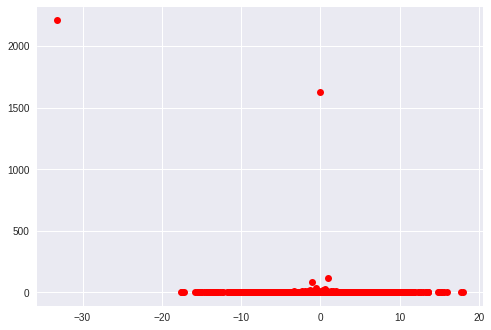



---End Line---




In [0]:
# @functools.lru_cache(maxsize=128)  # Note 2018/12/14: commented to avoid "TypeError: 'DataFrame' objects are mutable"
def check_survivor_bias(data_path, data, label):
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]    
    print("[Input] File Name: {}, survivor bias checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The distribution of existed target: ")
    
    target_set = list(set(data[label]))
    biascollector_survivor_dict = {each_target: len(data[label][data[label] == each_target]) for each_target in target_set}
    biascollector_survivor_df = pd.DataFrame(data=biascollector_survivor_dict, index=[0])
    biascollector_survivor_df.to_csv("./model/collector/bias_survivor_collector.csv", index=False)
    pprint.pprint(biascollector_survivor_df)    
    plt.plot(target_set, list(biascollector_survivor_dict.values()), 'ro', linewidth=2)
    plt.show()
    # sns.countplot(x='target', data=data_train);
    print("\n")
    print("---End Line---")
    print("\n")

    
check_survivor_bias(data_train_path, data_train, 'target')
# check_survivor_bias(data_test_path, data_test, '')

#### check time-related

In [0]:
# References: 
# jianshu.com/p/4130bac8ebe
# jianshu.com/p/9066b9e0c7af

data_train.rolling?

In [0]:
data_train_copy = copy.copy(data_train)
data_train_dates = list(set(data_train_copy['first_active_month']))
data_train_copy_slicedBydate = pd.DataFrame(data=[data_train_copy[data_train_copy['first_active_month'] == each_date].iloc[0, :] for each_date in data_train_dates], columns=data_train_copy.columns)
data_train_copy_slicedBydate.set_index(pd.to_datetime(data_train_copy_slicedBydate['first_active_month']), inplace=True)
data_train_copy_slicedBydate = data_train_copy_slicedBydate.sort_index()

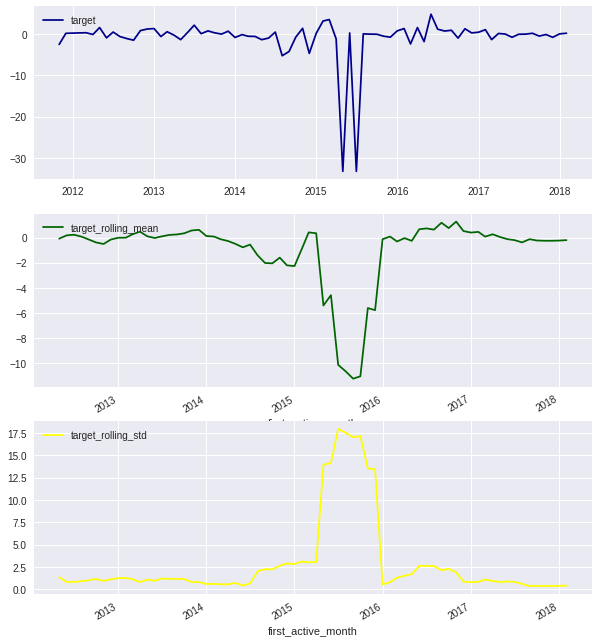

In [0]:
fig2 = plt.figure(figsize=(10, 12));
ax1 = fig2.add_subplot(311) 
plt.plot_date(x=data_train_copy_slicedBydate.index, y=data_train_copy_slicedBydate['target'], xdate=True, marker=None, linestyle='solid', color='darkblue', label='target');
plt.legend(loc='upper left');
ax2 = fig2.add_subplot(312) 
data_train_copy_slicedBydate['target'].rolling(6).mean().plot(color='darkgreen', label='target_rolling_mean');
plt.legend(loc='upper left');
ax3 = fig2.add_subplot(313) 
data_train_copy_slicedBydate['target'].rolling(6).std().plot(color='yellow', label='target_rolling_std');
plt.legend(loc='upper left');
# data_train_copy_slicedBydate_resampled = data_train_copy_slicedBydate.resample('W-MON')  # 数据太多时的降频处理, TODO 2018/12/17: ModuleNotFoundError: No module named 'pandas.core.groupby.groupby'; 'pandas.core.groupby' is not a package
# data_train_copy_slicedBydate_resampled.plot(color='darkred')

In [0]:
LABELS = ['adf statistics', 'p value', 'used lag', 'NUmber of oberservation']


# @functools.lru_cache(maxsize=128)
def check_adfuller(data):
    results = adfuller(x=data, maxlag=12)
    for label, result in zip(LABELS, results):
        print(label + ': ' + str(result))
    if results[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, accept the null hypothesis")
        print("Data has unit root and is non-stationary")    

In [0]:
check_adfuller(data_train_copy_slicedBydate['target'])

adf statistics: -4.327545497552187
p value: 0.00039787318845015395
used lag: 3
NUmber of oberservation: 71
Strong evidence against the null hypothesis, reject the null hypothesis
Data has no unit root and is stationary


[Input] Data: first derivative of 'target', visualization for VARIABLE "data_train_copy_slicedBydate['diff1']"
[Output] visualization of vacancy numbers
1


[Output] visualization of curve trend


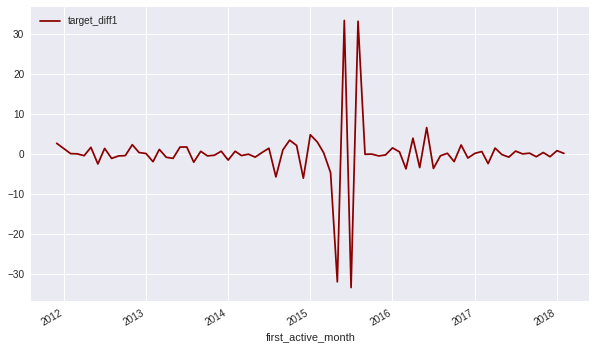



---End Line---


[Input] Data Part: second derivative of 'target', visualization for VARIABLE "data_train_copy_slicedBydate['diff2']"
[Output] visualization of vacancy numbers
2


[Output] visualization of curve trend


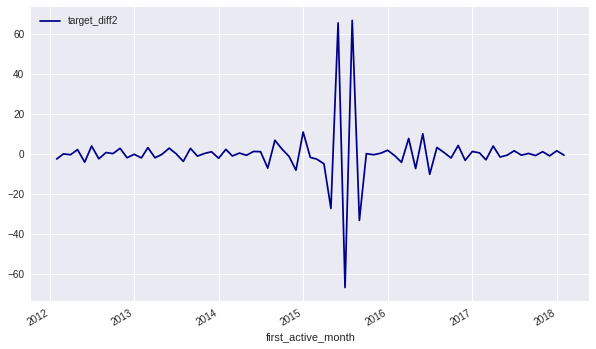



---End Line---




In [0]:
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
print("[Input] Data: {}, visualization for VARIABLE \"{}\"".format('first derivative of \'target\'', 'data_train_copy_slicedBydate[\'diff1\']'))
data_train_copy_slicedBydate['diff1'] = data_train_copy_slicedBydate['target'].diff(1)  # Note 2018/12/13: if needed, use '.dropna()''
# pprint.pprint(data_train_copy_slicedBydate['diff1'])
print("[Output] visualization of vacancy numbers")
pprint.pprint(data_train_copy_slicedBydate['diff1'].isnull().sum())
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate['diff1'].plot(color='darkred', label='target_diff1', ax=ax1)
plt.legend(loc='upper left')
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate['diff1'])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
print("[Input] Data Part: {}, visualization for VARIABLE \"{}\"".format('second derivative of \'target\'', 'data_train_copy_slicedBydate[\'diff2\']'))
data_train_copy_slicedBydate['diff2'] = data_train_copy_slicedBydate['diff1'].diff(1)
# pprint.pprint(data_train_copy_slicedBydate['diff2'])
print("[Output] visualization of vacancy numbers")
pprint.pprint(data_train_copy_slicedBydate['diff2'].isnull().sum())
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate['diff2'].plot(color='darkblue', label='target_diff2', ax=ax2)
plt.legend(loc='upper left')
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate['diff2'])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

[Input] Variable: ddata_train_copy_slicedBydate['diff1'], determine parameters 'p, d, q' for financial sequence model fetched from it
[Output] visualization of acf curve


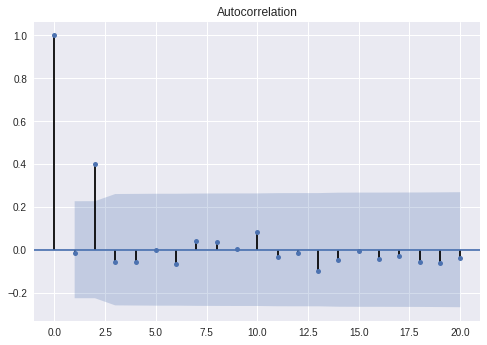



[Output] visualization of pacf curve


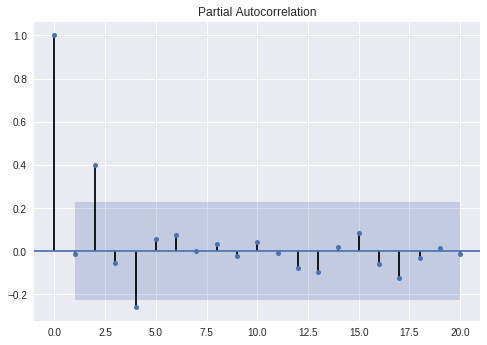

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):




---End Line---


[Input] Variable: result_arima, visualization of fitting results for financial sequence model 'ARIMA'
[Output] visualization of summary
                             ARIMA Model Results                              
Dep. Variable:               D.target   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -232.807
Method:                       css-mle   S.D. of innovations              5.598
Date:                Wed, 19 Dec 2018   AIC                            473.615
Time:                        09:17:37   BIC                            482.831
Sample:                    12-01-2011   HQIC                           477.291
                         - 02-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0165      0.328      0.050

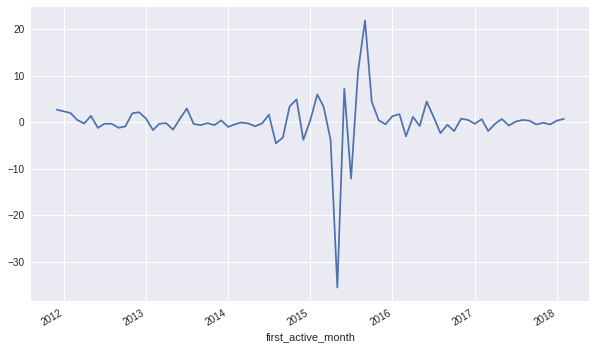

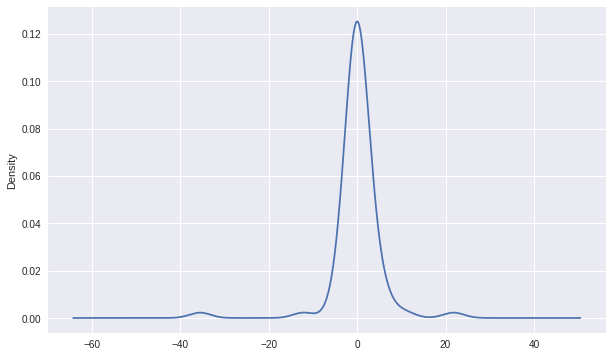



---End Line---




In [0]:
print("[Input] Variable: {}, determine parameters \'p, q\' for financial sequence model fetched from it".format('ddata_train_copy_slicedBydate[\'diff1\']'))
print("[Output] visualization of acf curve")
acf = plot_acf(data_train_copy_slicedBydate['target'], lags=20)
plt.show()
print("\n")
print("[Output] visualization of pacf curve")
pacf = plot_pacf(data_train_copy_slicedBydate['target'], lags=20)
plt.show()
model_arima = ARIMA(data_train_copy_slicedBydate['target'], order=(1, 1, 1), freq='W-MON')   # TODO 2018/12/19: check the right descriptions of choosing p and q from acf and pacf plotting 
result_arima = model_arima.fit()
print("\n")
print("---End Line---")
print("\n")

print("[Input] Variable: {}, visualization of fitting results for financial sequence model \'ARIMA\'".format('result_arima'))
print("[Output] visualization of summary")
print(result_arima.summary())
print("\n")
print("[Output] visualization of residual trend and distribution")
result_arima.resid.dropna(axis=0, inplace=True)
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
result_arima.resid.plot(ax=ax1)
plt.show()
fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
result_arima.resid.plot(ax=ax2, kind='kde')
plt.show()
print("\n")
print("---End Line---")
print("\n")

In [0]:
result_arima

In [0]:
data_train_copy_slicedBydate

In [0]:
print("[Input] Variable: {}, visualization of prediction results for financial sequence model \'ARIMA\'".format('result_arima'))
data_train_copy_slicedBydate['target_pred'] = result_arima.predict(start='2011-12-01', end='2018-02-01', typ='levels')
print("[Output] visualization of prediction curve compared with original curve")
data_train_copy_slicedBydate[['target', 'target_pred']].plot()
plt.show()
# pd.data_range(start='2018-12-1', end='2019-12-1', periods=12, freq='MS')
print("\n")
print("---End Line---")
print("\n")

[Input] Variable: result_arima, visualization of prediction results for financial sequence model 'ARIMA'


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: ignored

### collect nexus

In [0]:
data_info[0]

,0,1
0,train.csv,NaN
1,NaN,NaN
2,Columns,Description
3,card_id,Unique card identifier
4,first_active_month,"'YYYY-MM', month of first purchase"
5,feature_1,Anonymized card categorical feature
6,feature_2,Anonymized card categorical feature
7,feature_3,Anonymized card categorical feature
8,target,Loyalty numerical score calculated 2 months af...


#### divide data category

In [0]:
# @functools.lru_cache(maxsize=128)  # TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed
def collect_datatype(data):
    return {each_column: str(data[each_column].dtypes) for each_column in data.columns}


data_types_dict = {"historical_transactions_datatype": collect_datatype(data_historical_transactions), "new_merchant_transactions_datatype": collect_datatype(data_new_merchant_transactions), "merchants_datatype": collect_datatype(data_merchants), "trainOrtest_datatype": collect_datatype(data_train)}

In [0]:
data_types_dict

{'historical_transactions_datatype': {'authorized_flag': 'object',
  'card_id': 'object',
  'category_1': 'object',
  'category_2': 'float64',
  'category_3': 'object',
  'city_id': 'int64',
  'installments': 'int64',
  'merchant_category_id': 'int64',
  'merchant_id': 'object',
  'month_lag': 'int64',
  'purchase_amount': 'float64',
  'purchase_date': 'object',
  'state_id': 'int64',
  'subsector_id': 'int64'},
 'merchants_datatype': {'active_months_lag12': 'int64',
  'active_months_lag3': 'int64',
  'active_months_lag6': 'int64',
  'avg_purchases_lag12': 'float64',
  'avg_purchases_lag3': 'float64',
  'avg_purchases_lag6': 'float64',
  'avg_sales_lag12': 'float64',
  'avg_sales_lag3': 'float64',
  'avg_sales_lag6': 'float64',
  'category_1': 'object',
  'category_2': 'float64',
  'category_4': 'object',
  'city_id': 'int64',
  'merchant_category_id': 'int64',
  'merchant_group_id': 'int64',
  'merchant_id': 'object',
  'most_recent_purchases_range': 'object',
  'most_recent_sales_ran

In [0]:
# 2019/1/8: check for the work above to avoid type missing caused by 'Nan' with assumption as  all data in same column share the same data type

data_types_collector = {}
for data_type in data_types_dict:
    data_types_collector[data_type] = {'Num':[], 'Non-Num':[], 'Mixed':[], 'Categorical':[]}
    print("[Output] The non-numbericial columns of {}".format(data_type))
    
    # pprint.pprint({each_column: [str(type(data_types_dict[data_type][each_column][0])) if 'object' in data_types_dict[data_type][each_column] else pass] for each_column in list(data_types_dict[data_type].keys())})
    
    for each_column in list(data_types_dict[data_type].keys()):
        if 'object' in data_types_dict[data_type][each_column]:
            data_types_collector[data_type]['Non-Num'].append(each_column)
            pprint.pprint("{} is stored as type {}".format(each_column, str(type(data_types_dict[data_type][each_column][0]))))
        else:
            data_types_collector[data_type]['Num'].append(each_column)
    print("The ratio of non-numbericial columns is {}".format(len(data_types_collector[data_type]['Non-Num'])/len(data_types_dict[data_type].keys())))
    print("\n")
    print("---End Line---")
    print("\n")

[Output] The non-numbericial columns of historical_transactions_datatype
"authorized_flag is stored as type <class 'str'>"
"card_id is stored as type <class 'str'>"
"category_1 is stored as type <class 'str'>"
"category_3 is stored as type <class 'str'>"
"merchant_id is stored as type <class 'str'>"
"purchase_date is stored as type <class 'str'>"


---End Line---


[Output] The non-numbericial columns of new_merchant_transactions_datatype
"authorized_flag is stored as type <class 'str'>"
"card_id is stored as type <class 'str'>"
"category_1 is stored as type <class 'str'>"
"category_3 is stored as type <class 'str'>"
"merchant_id is stored as type <class 'str'>"
"purchase_date is stored as type <class 'str'>"


---End Line---


[Output] The non-numbericial columns of merchants_datatype
"merchant_id is stored as type <class 'str'>"
"category_1 is stored as type <class 'str'>"
"most_recent_sales_range is stored as type <class 'str'>"
"most_recent_purchases_range is stored as type <class 

In [10]:
import pickle

# fw = open(DATA_ROOT_PATH+"/collector/data_types.pkl", "wb")
# pickle.dump(data_types_collector, fw)
# fw.close()

fr = open(DATA_ROOT_PATH+"/collector/data_types.pkl", "rb")
data_types_collector = pickle.load(fr)
fr.close()

#### expand training and testing data

In [0]:
data_new_merchant_transactions.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [0]:
data_test = copy.copy(data_train)
len(data_test) == len(set(data_test["card_id"][:]))
column_ref = "card_id"
id_diff = list(set(data_train[column_ref]).intersection(set(data_new_merchant_transactions[column_ref])))
data_new_merchant_transactions.set_index(data_new_merchant_transactions['card_id'], inplace=True)
data_new_merchant_transactions['city_id'][id_diff]

In [0]:
# @functools.lru_cache(maxsize=128)  # TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed
def expand_data(data_ori, data_external, column_ref):
    
    # columns_added = [each_column if each_column not in data_ori.columns else 'Exisisted' for each_column in data_external.columns]
    
    if len(data_ori) == len(set(data_ori.loc[:, column_ref])):
        pass
    else:
        pass # TODO 2019/1/9: how to deal this situation? 
    data_new = copy.copy(data_ori)
    data_external_mod1 = copy.copy(data_external) 
    data_external_mod1.drop_duplicates(subset="card_id", inplace=True)  # TODO 2019/1/14: how to deal with the duplicate transaction record? 
    columns_added = []
    for each_column in data_external.columns:
        if each_column not in data_ori.columns:
            columns_added.append(each_column)
            data_new[each_column] = np.array([np.nan] * len(data_ori))
    
    # content = [data_external[columns_added][data_external[column_ref]==index] for index in data_ori[column_ref]]  # TODO 2019/1/9: a more efficient way to expand whole data?
    
    id_inter = list(set(data_new[column_ref]).intersection(set(data_external_mod1[column_ref])))
    # return(id_inter)
    data_new.set_index(data_new[column_ref], inplace=True)
    data_external_mod1.set_index(data_external_mod1[column_ref], inplace=True)   
    data_new.loc[id_inter, columns_added] = data_external_mod1.loc[id_inter, columns_added]  # TODO 2019/1/11: ValueError: cannot reindex from a duplicate axis
    return data_new

In [0]:
data_train_mod1 = expand_data(data_train, data_new_merchant_transactions, "card_id")
data_train_mod2 = expand_data(data_train_mod1, data_historical_transactions, "card_id")
print("[Output] Save expanded training data by raw data file {}: ".format("data_new_merchant_transactions"))
data_train_mod1.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded.csv")
print("[Output] Save expanded training data by raw data file {} and {}: ".format("data_new_merchant_transactions", "data_historical_transactions"))
data_train_mod2.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded2.csv")

[Output] Save expanded training data by raw data file data_new_merchant_transactions: 
[Output] Save expanded training data by raw data file data_new_merchant_transactions and data_historical_transactions: 


In [0]:
data_test_mod1 = expand_data(data_test, data_new_merchant_transactions, "card_id")
data_test_mod2 = expand_data(data_test_mod1, data_historical_transactions, "card_id")
print("[Output] Save expanded testing data by raw data file {}: ".format("data_new_merchant_transactions"))
data_test_mod1.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded.csv")
print("[Output] Save expanded testing data by raw data file {} and {}: ".format("data_new_merchant_transactions", "data_historical_transactions"))
data_test_mod2.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded2.csv")

[Output] Save expanded testing data by raw data file data_new_merchant_transactions: 
[Output] Save expanded testing data by raw data file data_new_merchant_transactions and data_historical_transactions: 


In [11]:
data_train_mod1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded.csv")
data_train_mod2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded2.csv")
data_test_mod1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded.csv")
data_test_mod2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded2.csv")

#### nexus from training and testing data

In [12]:
columns_num = []
for each_csv in data_types_collector:
    for each_column in data_types_collector[each_csv]["Num"]:
        columns_num.append(each_column)
columns_num = set(columns_num)

In [13]:
data_train_mod2_columns_nonnum = set(data_train_mod2.columns).difference(columns_num)
data_train_mod2_columns_num = set(data_train_mod2.columns).difference(data_train_mod2_columns_nonnum)
data_test_mod2_columns_nonnum = set(data_test_mod2.columns).difference(columns_num)
data_test_mod2_columns_num = set(data_test_mod2.columns).difference(data_test_mod2_columns_nonnum)
data_train_mod2_num = data_train_mod2.loc[:, list(data_train_mod2_columns_num)]
data_train_mod2_nonnum = data_train_mod2.loc[:, list(data_train_mod2_columns_nonnum)]
data_test_mod2_num = data_test_mod2.loc[:, list(data_test_mod2_columns_num)]
data_test_mod2_nonnum = data_test_mod2.loc[:, list(data_test_mod2_columns_nonnum)]

In [0]:
def compare_dis(data_low_vacancy, data_high_vacancy, feat, ind):
    fig = plt.figure(num=ind, figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax1.set_title("feat %s from low vacancy data" %feat)
    mean_dict['low_vacancy_data'].append(data_low_vacancy[feat].dropna().mean())
    std_dict['low_vacancy_data'].append(data_low_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_low_vacancy, ax=ax1);
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("feat %s from high vacancy data" %feat)
    mean_dict['high_vacancy_data'].append(data_high_vacancy[feat].dropna().mean())
    std_dict['high_vacancy_data'].append(data_high_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_high_vacancy, ax=ax2);
    # sns.catplot(x="class", hue="who", col="survived", data=titanic, kind="count", height=4, aspect=.7);

- seperate adjustment(training data)

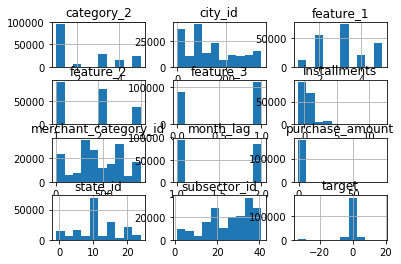

In [0]:
data_train_mod2_num.iloc[:, :].hist();

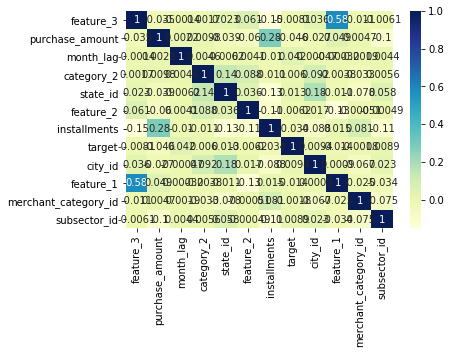

In [0]:
data_train_mod2_num_partcopy = data_train_mod2_num.iloc[:, :].copy()
sns.heatmap(data_train_mod2_num_partcopy.corr(), annot = True, cmap = "YlGnBu");

In [0]:
data_train_mod2_vacancy_asses = data_train_mod2.isnull().sum()
data_train_mod2_vacancy_asses

card_id                     0
first_active_month          0
card_id.1                   0
feature_1                   0
feature_2                   0
feature_3                   0
target                      0
authorized_flag         21931
city_id                 21931
category_1              21931
installments            21931
category_3              28285
merchant_category_id    21931
merchant_id             24949
month_lag               21931
purchase_amount         21931
purchase_date           21931
category_2              35592
state_id                21931
subsector_id            21931
dtype: int64

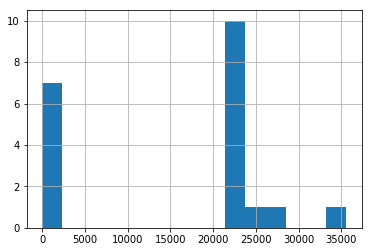

In [0]:
data_train_mod2_vacancy_asses.hist(bins=15);

In [0]:
data_train_mod2_row_vacancy_asses = np.array([data_train_mod2.iloc[indent, :].isnull().sum() for indent in range(len(data_train_mod2))])
row_vacancy_ave = data_train_mod2_row_vacancy_asses.sum() / (len(data_train_mod2_row_vacancy_asses))
data_train_mod2_low = data_train_mod2[:][data_train_mod2_row_vacancy_asses <= row_vacancy_ave]  # lower than average number
data_train_mod2_high = data_train_mod2[:][data_train_mod2_row_vacancy_asses > row_vacancy_ave]  # higher than average number

In [0]:
row_vacancy_ave

1.5260527840647395

In [0]:
len(data_train_mod2_row_vacancy_asses[(data_train_mod2_row_vacancy_asses != 0) == True])

43998

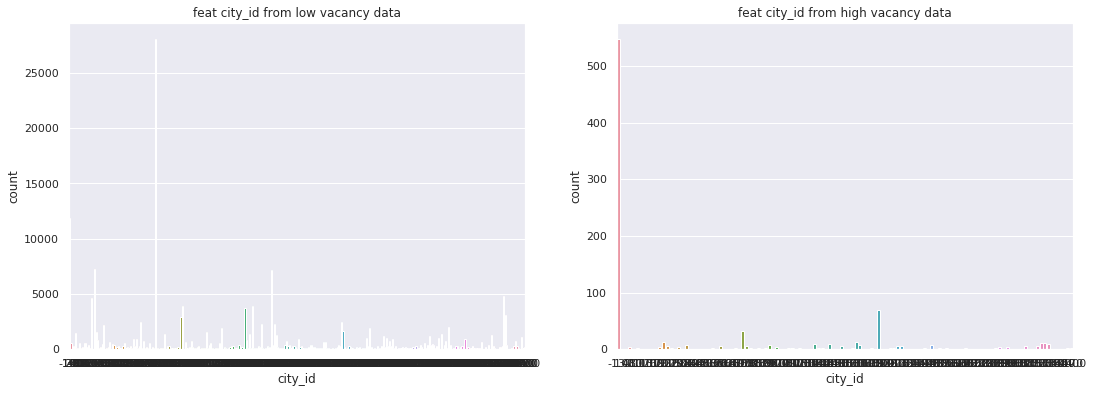

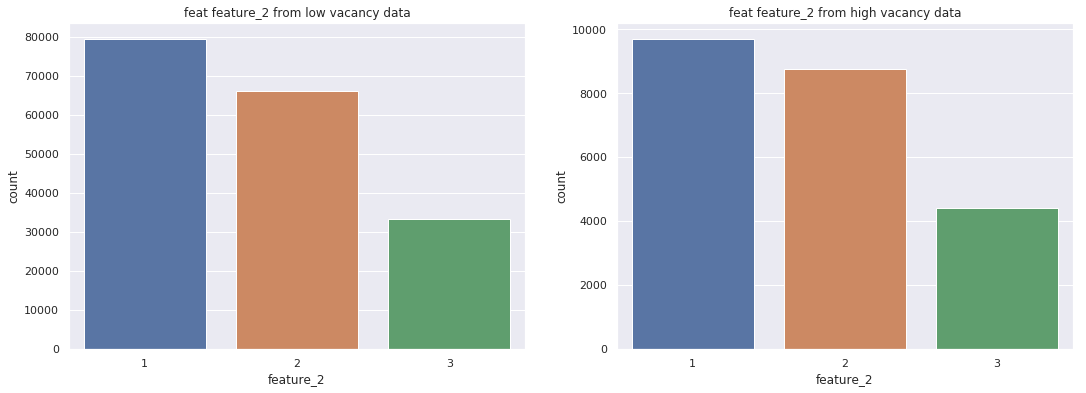

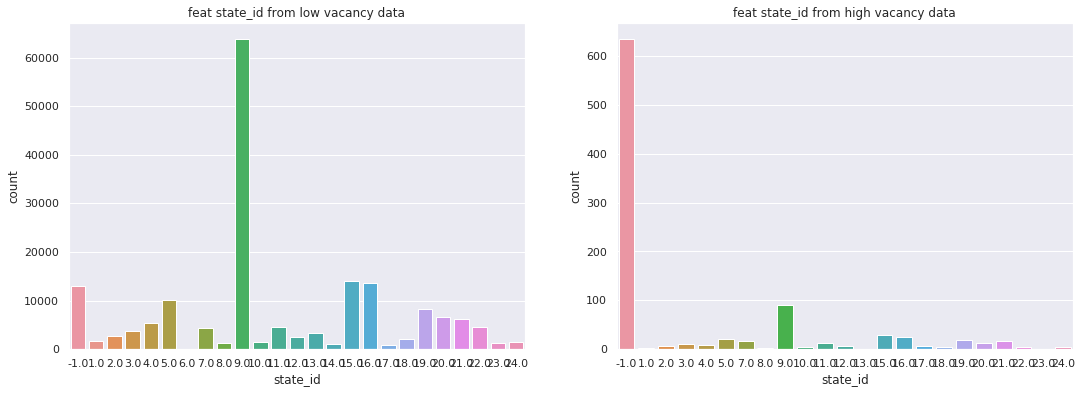

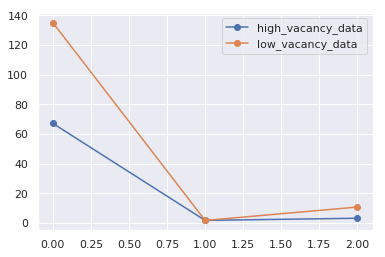

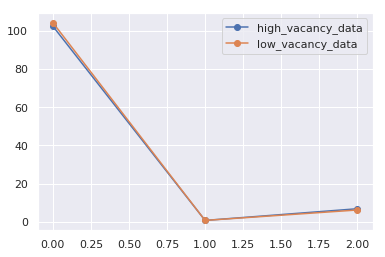

In [0]:
num = 3
mean_dict, std_dict = {'low_vacancy_data':[], 'high_vacancy_data':[]}, {'low_vacancy_data':[], 'high_vacancy_data':[]}
sns.set(style="darkgrid")
feat_selected = random.sample(list(data_train_mod2_columns_num), num)
for indent in range(num):
    compare_dis(data_train_mod2_low.loc[:, list(data_train_mod2_columns_num)], data_train_mod2_high.loc[:, list(data_train_mod2_columns_num)], feat_selected[indent], indent)
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)
mean_df.plot(marker='o');
std_df.plot(marker='o');

- seperate adjustment(testing data)

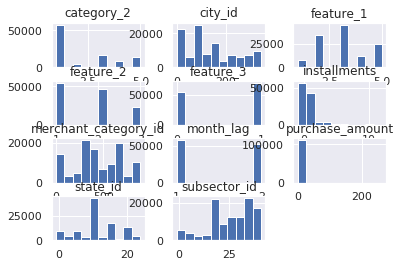

In [0]:
data_test_mod2_num.iloc[:, :].hist();

In [0]:
data_test_mod2_vacancy_asses = data_test_mod2.isnull().sum()
data_test_mod2_vacancy_asses

card_id                     0
first_active_month          1
card_id.1                   0
feature_1                   0
feature_2                   0
feature_3                   0
authorized_flag         13608
city_id                 13608
category_1              13608
installments            13608
category_3              17596
merchant_category_id    13608
merchant_id             15465
month_lag               13608
purchase_amount         13608
purchase_date           13608
category_2              21933
state_id                13608
subsector_id            13608
dtype: int64

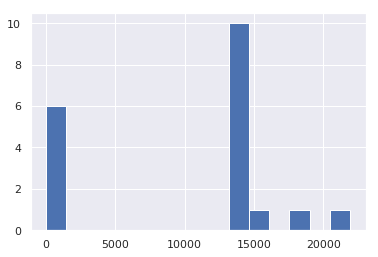

In [0]:
data_test_mod2_vacancy_asses.hist(bins=15);

In [0]:
data_test_mod2_row_vacancy_asses = np.array([data_test_mod2.iloc[indent, :].isnull().sum() for indent in range(len(data_test_mod2))])
row_vacancy_ave = data_test_mod2_row_vacancy_asses.sum() / (len(data_test_mod2_row_vacancy_asses))
data_test_mod2_low = data_test_mod2[:][data_test_mod2_row_vacancy_asses <= row_vacancy_ave]  # lower than average number
data_test_mod2_high = data_test_mod2[:][data_test_mod2_row_vacancy_asses > row_vacancy_ave]  # higher than average number

In [0]:
row_vacancy_ave

1.5456266228776199

In [0]:
len(data_test_mod2_row_vacancy_asses[(data_test_mod2_row_vacancy_asses != 0) == True])

27215

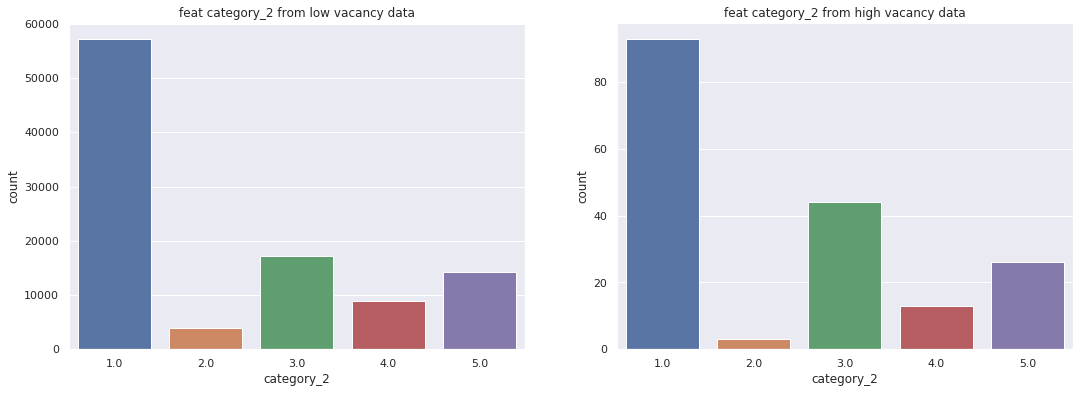

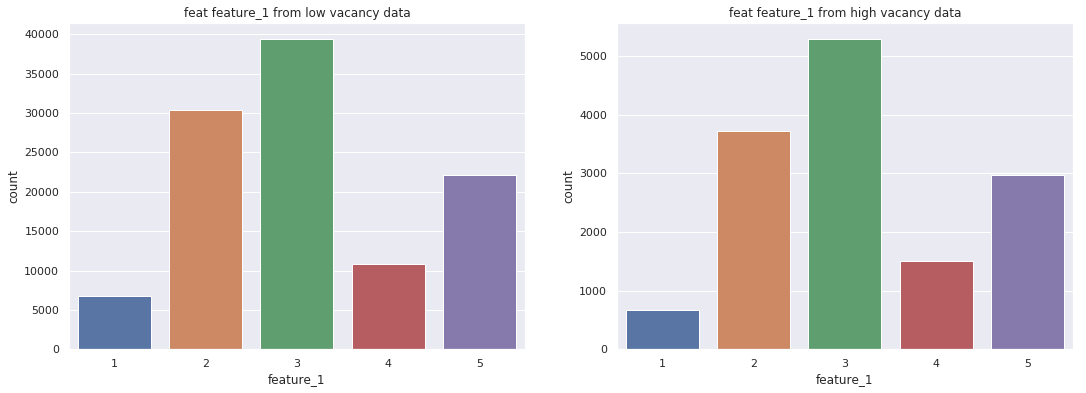

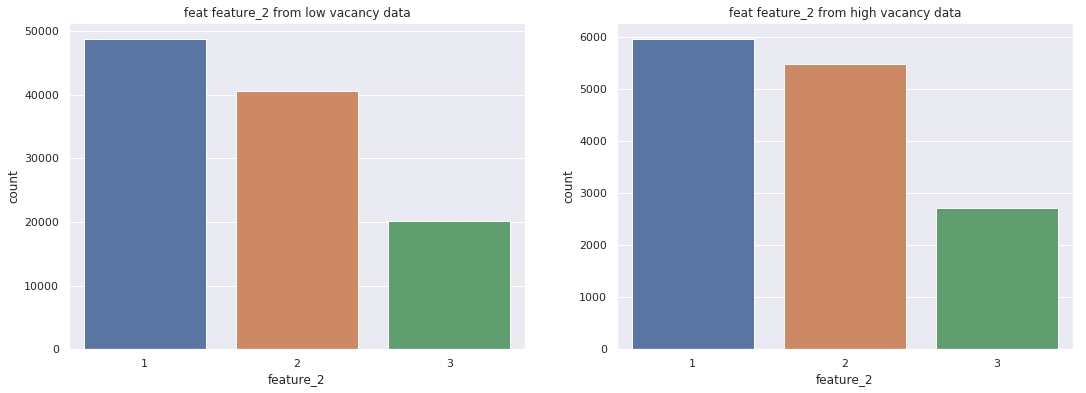

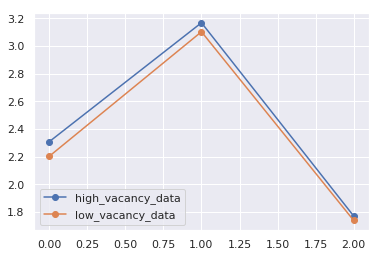

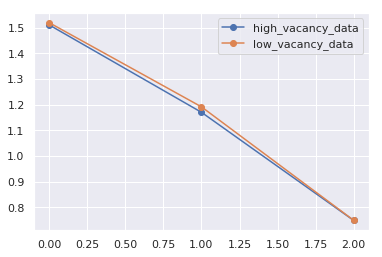

In [0]:
num = 3
mean_dict, std_dict = {'low_vacancy_data':[], 'high_vacancy_data':[]}, {'low_vacancy_data':[], 'high_vacancy_data':[]}
sns.set(style="darkgrid")
feat_selected = random.sample(list(data_test_mod2_columns_num), num)
for indent in range(num):
    compare_dis(data_test_mod2_low.loc[:, list(data_test_mod2_columns_num)], data_test_mod2_high.loc[:, list(data_test_mod2_columns_num)], feat_selected[indent], indent)
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)
mean_df.plot(marker='o');
std_df.plot(marker='o');

- combination adjustment

In [0]:
print(data_train_mod2.columns)
print(data_test_mod2.columns)

Index(['card_id', 'first_active_month', 'card_id.1', 'feature_1', 'feature_2',
       'feature_3', 'target', 'authorized_flag', 'city_id', 'category_1',
       'installments', 'category_3', 'merchant_category_id', 'merchant_id',
       'month_lag', 'purchase_amount', 'purchase_date', 'category_2',
       'state_id', 'subsector_id'],
      dtype='object')
Index(['card_id', 'first_active_month', 'card_id.1', 'feature_1', 'feature_2',
       'feature_3', 'authorized_flag', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')


The distribution of feature feature_3: 


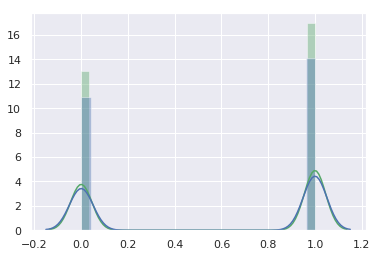

In [0]:
select_num = 1
feature = np.random.choice(list(data_test_mod2_columns_num), select_num)  # TODO 2019/1/16: how to deal with the exisited NaN?

for indent in range(select_num):
    print("The distribution of feature {}: ".format(feature[indent]))
    sns.distplot(data_train_mod2_num[feature], color='g')
    sns.distplot(data_test_mod2_num[feature], color='b')

##### Conclusions at 2019/1/16:
- It seems like data needs expansion instead of squeezing because of the insufficient features and insufficient description of data
- Compare column vacancy, vacancy distributes nearly equally except for the original columns of training data(no vacancy)
- Compare row vacancy, different columns may not cause considerate distribution differences, which indicates no change will be applied

In [0]:
data_train_mod2_columns_nonnum

['category_3',
 'first_active_month',
 'authorized_flag',
 'merchant_id',
 'category_1',
 'purchase_date']

In [14]:
data_train_mod2_nonnum.fillna(method='ffill', inplace=True)
data_test_mod2_nonnum.fillna(method='ffill', inplace=True)

In [15]:
# 2019/1/17: Try to avoid MemoryError 

data_train_mod2_columns_nonnum = list(data_train_mod2_columns_nonnum)
# data_train_mod2_columns_nonnum.remove("card_id")
data_train_mod2_columns_nonnum.remove("card_id.1")
data_train_mod2_columns_nonnum.remove("merchant_id")
data_train_mod2_columns_nonnum.remove("purchase_date")
data_train_mod2_columns_nonnum.remove("authorized_flag")

data_test_mod2_columns_nonnum = list(data_test_mod2_columns_nonnum)
# data_test_mod2_columns_nonnum.remove("card_id")
data_test_mod2_columns_nonnum.remove("card_id.1")
data_test_mod2_columns_nonnum.remove("merchant_id")
data_test_mod2_columns_nonnum.remove("purchase_date")
data_test_mod2_columns_nonnum.remove("authorized_flag")

In [0]:
print(data_train_mod2_columns_nonnum, data_test_mod2_columns_nonnum)

['category_1', 'first_active_month', 'category_3'] ['category_1', 'first_active_month', 'category_3']


In [16]:
@functools.lru_cache(maxsize=128) 
def sum_numberical(strings):
    indent = 0
    for each_str in strings:
        try:
            indent += int(each_str)
        except ValueError:
            indent += ord(each_str)
    return indent

In [17]:
temp = [sum_numberical(each_id.split("C_ID_")[1]) for each_id in data_train_mod2_nonnum["card_id"]]
data_train_mod2_nonnum["card_id"] = temp
data_train_mod2_columns_nonnum.remove("card_id")

In [18]:
temp = [sum_numberical(each_id.split("C_ID_")[1]) for each_id in data_test_mod2_nonnum["card_id"]]
data_test_mod2_nonnum["card_id"] = temp
data_test_mod2_columns_nonnum.remove("card_id")

In [20]:
data_train_mod2_nonnum_converted = pd.get_dummies(data_train_mod2_nonnum.loc[:, data_train_mod2_columns_nonnum])
data_test_mod2_nonnum_converted = pd.get_dummies(data_test_mod2_nonnum.loc[:, data_test_mod2_columns_nonnum])

In [21]:
from sklearn.preprocessing import Imputer


filler_vacancy = Imputer()
data_train_mod2_num['card_id'] = data_train_mod2_nonnum["card_id"] 
data_test_mod2_num['card_id'] = data_test_mod2_nonnum["card_id"] 
data_train_mod2_num_nonull = pd.DataFrame(data=filler_vacancy.fit_transform(data_train_mod2_num), columns=data_train_mod2_num.columns)
data_test_mod2_num_nonull = pd.DataFrame(data=filler_vacancy.fit_transform(data_test_mod2_num), columns=data_test_mod2_num.columns)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


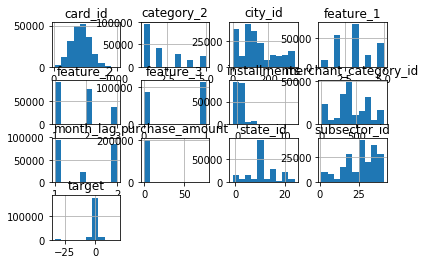

In [32]:
data_train_mod2_num_nonull.hist();

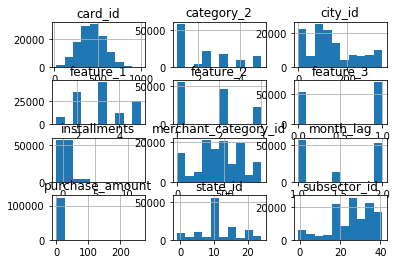

In [33]:
data_test_mod2_num_nonull.hist();

The distribution of feature city_id: 


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


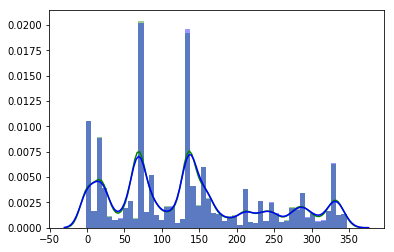

In [0]:
select_num = 1
feature = np.random.choice(list(data_test_mod2_columns_num), select_num)  # TODO 2019/1/16: how to deal with the exisited NaN?

for indent in range(select_num):
    print("The distribution of feature {}: ".format(feature[indent]))
    sns.distplot(data_train_mod2_num_nonull[feature], color='g')
    sns.distplot(data_test_mod2_num_nonull[feature], color='b')

In [25]:
data_train_full = pd.concat([data_train_mod2_nonnum_converted, data_train_mod2_num_nonull], axis=1)
data_test_full = pd.concat([data_test_mod2_nonnum_converted, data_test_mod2_num_nonull], axis=1)
print("[Output] Save full training data after expansion, comparison and filling nan: ")
data_train_full.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full.csv", index=None)
print("[Output] Save full testing data  after expansion, comparison and filling nan: ")
data_test_full.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full.csv", index=None)

[Output] Save full training data after expansion, comparison and filling nan: 
[Output] Save full testing data  after expansion, comparison and filling nan: 


In [0]:
data_train_full = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full.csv")
data_test_full = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full.csv")

## last process

In [0]:
class process_last(self):
    def __init__(self):
        allocate room for the variable returned by class process_mid_c
        
    def apply_scaler(self):
        use different scalers provided by sklearn with consideration of model feed
        return dataframe xxx_filled_scaled after scaling
    
    def select_feat(self):
        use algorithms like RF(SL), Kmeans(UL) or functions from sklearn
        return dataframe xxx_filled_scaled_selected after selection

In [0]:
import gc
gc.collect()
sys._clear_type_cache()

### apply scaler

In [38]:
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import Normalizer


scaler_std = StandardScaler()
data_train_full_scaled = pd.DataFrame(data=scaler_std.fit_transform(data_train_full.iloc[:, :-1]), columns=data_train_full.columns[:-1])
data_test_full_scaled = pd.DataFrame(data=scaler_std.fit_transform(data_test_full.iloc[:, :-1]), columns=data_test_full.columns[:-1])
data_train_full_scaled["card_id"] = data_train_full["card_id"]
data_test_full_scaled["card_id"] = data_test_full["card_id"]

In [39]:
print("[Output] Save sacled training data after expansion, comparison and filling nan: ")
data_train_full_scaled.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled.csv", index=None)
print("[Output] Save scaled testing data  after expansion, comparison and filling nan: ")
data_test_full_scaled.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled.csv", index=None)

[Output] Save sacled training data after expansion, comparison and filling nan: 
[Output] Save scaled testing data  after expansion, comparison and filling nan: 


In [ ]:
data_train_full_scaled = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled.csv")
data_test_full_scaled = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled.csv")

### select feat

In [40]:
from sklearn import feature_selection


def select_feature(features_num, data, labels):
    fselector = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=features_num)
    fselector.fit(data, labels)
    mask = fselector.get_support()
    indent = 0
    feature_names_selected = []
    for indent in range(len(mask)):
        if mask[indent]:
            feature_names_selected.append(list(data.columns)[indent])
        gc.collect()
    return  feature_names_selected

In [42]:
labels_train = data_train_full["target"].astype("float")
labels_train.to_csv(DATA_ROOT_PATH+"data_raw/labels_total.csv", index=None)

In [8]:
data_train_full_scaled.columns

Index(['category_3_A', 'category_3_B', 'category_3_C', 'category_1_N',
       'category_1_Y', 'first_active_month_2011-11',
       'first_active_month_2011-12', 'first_active_month_2012-02',
       'first_active_month_2012-03', 'first_active_month_2012-04',
       'first_active_month_2012-05', 'first_active_month_2012-06',
       'first_active_month_2012-07', 'first_active_month_2012-08',
       'first_active_month_2012-09', 'first_active_month_2012-10',
       'first_active_month_2012-11', 'first_active_month_2012-12',
       'first_active_month_2013-01', 'first_active_month_2013-02',
       'first_active_month_2013-03', 'first_active_month_2013-04',
       'first_active_month_2013-05', 'first_active_month_2013-06',
       'first_active_month_2013-07', 'first_active_month_2013-08',
       'first_active_month_2013-09', 'first_active_month_2013-10',
       'first_active_month_2013-11', 'first_active_month_2013-12',
       'first_active_month_2014-01', 'first_active_month_2014-02',
     

In [45]:
import math


labels_train = [math.floor(item) for item in data_train_full["target"].astype("float")]
data_train_part_scaled = data_train_full_scaled.drop(["target"], axis=1)
feature_train_selected = select_feature(25, data_train_part_scaled, labels_train)
data_train_full_scaled_selected = data_train_full_scaled.loc[:, feature_train_selected]
data_test_full_scaled_selected = data_test_full_scaled.loc[:, feature_train_selected]

data_train_full_scaled_selected["card_id"] = data_train_full["card_id"]
data_test_full_scaled_selected["card_id"] = data_test_full["card_id"]

In [46]:
print("[Output] Save selected training data after expansion, comparison, filling nan and scaling: ")
data_train_full_scaled_selected.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv", index=None)
print("[Output] Save scaled testing data after expansion, comparison, filling nan and scaling: ")
data_test_full_scaled_selected.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv", index=None)

[Output] Save selected training data after expansion, comparison, filling nan and scaling: 
[Output] Save scaled testing data after expansion, comparison, filling nan and scaling: 


In [6]:
data_train_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv")
data_test_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv")

# Test Parts

In [0]:
ax2 = fig.add_subplot(122)
ax2.set_title("feat %s from high vacancy data" %feat)
sns.countplot(x=feat, data=data_high_vacancy, ax=ax2);

In [0]:
data_stock = ts.get_hist_data('600519')
data_stock.isna().sum()
# data_stock.index

In [0]:
print(data_stock.columns, type(data_stock))

In [0]:
mean_dict, std_dict = {'feat_low_vacancy':[], 'feat_high_vacancy':[]}, {'feat_low_vacancy':[], 'feat_high_vacancy':[]}
sns.set(style="darkgrid")
def compare_dis(data_low_vacancy, data_high_vacancy, feat_low_vacancy_si, feat_high_vacancy_si, ind):
    fig = plt.figure(num=ind, figsize=(10, 15))
    ax1 = fig.add_subplot(211)
    ax1.set_title("feat %s from low vacancy data" %feat_low_vacancy_si)
    mean_dict['feat_low_vacancy'].append(data_low_vacancy[feat_low_vacancy_si].dropna().mean())
    std_dict['feat_low_vacancy'].append(data_low_vacancy[feat_low_vacancy_si].dropna().std())
    sns.countplot(x=feat_low_vacancy_si, data=data_low_vacancy, ax=ax1);
    
    ax2 = fig.add_subplot(212)
    ax2.set_title("feat %s from high vacancy data" %feat_high_vacancy_si)
    mean_dict['feat_high_vacancy'].append(data_high_vacancy[feat_high_vacancy_si].dropna().mean())
    std_dict['feat_high_vacancy'].append(data_high_vacancy[feat_high_vacancy_si].dropna().std())
    sns.countplot(x=feat_high_vacancy_si, data=data_high_vacancy, ax=ax2);
    # sns.catplot(x="class", hue="who", col="survived", data=titanic, kind="count", height=4, aspect=.7);
    
num = 5
feats_low_selected = random.sample(list(azdias_low.columns), num)
feats_high_selected = random.sample(list(azdias_high.columns), num)
for indent in range(num):
    compare_dis(azdias_low, azdias_high, feats_low_selected[indent], feats_high_selected[indent], indent)
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)